# Project: Investigate alcohol consumption
## Table of contents
 - <a href="#intro">Introduction</a>
 - <a href="#wrangle">Data wrangling and cleaning</a>
 - <a href="#explore">Exploratory analysis</a>
 - <a href="#discussion">Discussion</a>

<a id="intro"></a>
## Introduction

For my analysis project, I choose the *"Gapminder World"* dataset. After I looked through the available variables, I chose *"Alcohol consumption per adult"* indicator as the dependent variable and the following three as the independent variable: 

 - *"Prevalence of current tobacco use among adults (>=15 years) (%, both sexes)"*
 - *"Income per person (fixed 2000 US$)"*
 - *"Total 15+ unemployed (%)"*

After the initial examination, I found that the matrix of measurements are extremely sparse, but the column for 2005 was quite filled, so I decided to take only this year into account.

Using these variables, I decided to answer this three questions:

 1. "How does the economy of a country relate to alcohol consumption?"
 2. "Is there any connection between addiction to alcohol and tobacco?"
 3. "Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?"

In [76]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

# Magic word for plots
%matplotlib inline

# Define basic variables
DATA_DIR = 'ds'
FILE_NAMES = ['alcohol', 'smoking', 'income', 'unemployment']
levels = ['low', 'avg', 'high'] # alcohol consumption level
level_colors = {'low': 'b', 'avg': 'g', 'high': 'r'} # color for level

In [77]:
# Utility function definitions


def calc_zscore_single(population, element, feature) : 
    pop_mu = population.loc[:, feature].mean()
    pop_sd = population.loc[:, feature].std()
    return (element[feature] - pop_mu) / pop_sd

<a id="wrangle"></a>
## Data wrangling and cleaning

### Loading data
As a first step, I loaded each dataset into dataframe and I put them in a list. I used the name of the country as index and the name of the file as column name. After that, I joined the dataframes by the name of the country.

In [78]:
df_list = []
for fname in FILE_NAMES :
    full_path = DATA_DIR + '/' + fname + '.csv'
    df = pd.read_csv(full_path, index_col=0, header=0, sep=',')
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)

### Cleaning
I wanted to use the same set of countries for all of my three questions. But, different countries had different missing values. To preserve the consistency, I decided to retain only those countries for which I had a value for all four indicators.

My third (bonus) question was to inspect the state of Hungary, so I saved it for later use (because the unemployment ratio is missing, it will drop out from the global dataset).

In [79]:
print('Number of countries in the original dataset: {}'.format(len(df)))

df_hun = df.loc['Hungary'] #Save Hungary for later usage
df = df.dropna() # Remove countries with missing value

print('Number of countries after removing missing value: {}'.format(len(df)))

Number of countries in the original dataset: 295
Number of countries after removing missing value: 24


I was curious about which countries remained, so I printed out them:

In [80]:
print(', '.join(list(df.index)))

Australia, Canada, Estonia, Finland, France, Germany, Ireland, Japan, Latvia, Lithuania, Netherlands, New Zealand, Norway, Philippines, Poland, Portugal, Romania, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States


### Handling possible outliers

I know that all country in my dataset has all four measurements. But is there any outlier which we need to handle? I plot a histogram for each variable and looked at them.

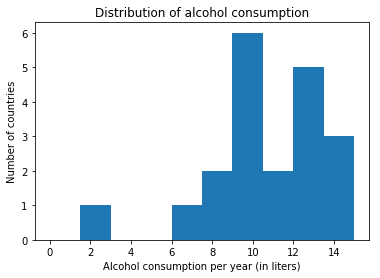

In [81]:
hist1 = df.loc[:, 'alcohol'].hist(grid=False, bins=10, range=(0,15))
plt.xlabel('Alcohol consumption per year (in liters)')
plt.ylabel('Number of countries')
hist1 = plt.title('Distribution of alcohol consumption')

On this histogram I can see one outlier where the yearly consumption fall far from the other values. I selected this country by value:

In [82]:
outlier_country = list(df.loc[df.loc[:,'alcohol'] < 5].index)
print('Possible utlier country based on alcohol consumption: ' + ', '.join(outlier_country))

Possible utlier country based on alcohol consumption: Turkey


I examined the three independent variable too the same way.

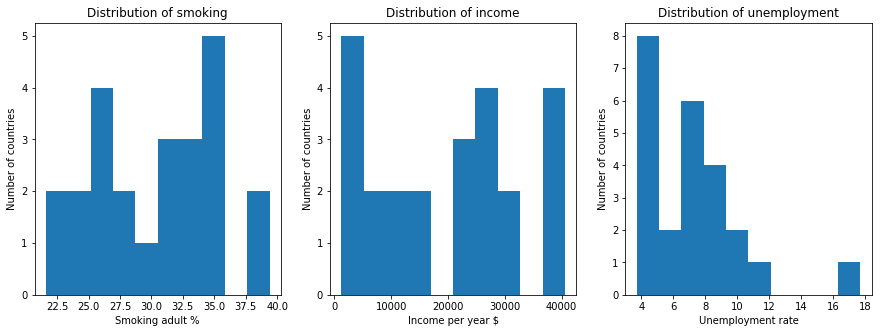

In [83]:
histogram_list = [[] for i in range(0, 3)]
xlabel_list = ['Smoking adult %', 'Income per year $', 'Unemployment rate']
plt.figure(figsize=(15,5))
for i in range(1, 4) :
    plt.subplot(1, 3, i)
    histogram_list[i-1] = df.loc[:, FILE_NAMES[i]].hist(grid=False)
    plt.xlabel(xlabel_list[i-1])
    plt.ylabel('Number of countries')
    plt.title('Distribution of ' + FILE_NAMES[i])

In [84]:
smoking_outlier = list(df.loc[df.loc[:, 'smoking']>35].index)
print('Outlier countries based on smoking: ' + ', '.join(smoking_outlier))

Outlier countries based on smoking: Estonia, Latvia, Poland, Portugal, Turkey, United Kingdom


In [85]:
unemp_outlier = list(df.loc[df.loc[:, 'unemployment']>15].index)
print('Outlier countries based on unemployment ratio: ' + ', '.join(unemp_outlier))

Outlier countries based on unemployment ratio: Poland


Looking at the histogram, I didn't consider any country as possible outlier based on income. I think these values don't seem to be invalid or erroneous so I decided to retain them in my analysis.

### General properties of dataset

After the initial cleaning step I calculated some basic statistics.

In [86]:
for field in ['alcohol', 'smoking', 'income', 'unemployment'] :
    (stat,pval) = sts.normaltest(df.loc[:, field].values)
    
    if pval < 0.05 :
        decision = 'rejected'
    else :
        decision = 'accepted'
        
    print('Normality of variable \'' + field + '\' is {} at 0.05 significance level.'.format(decision))

Normality of variable 'alcohol' is accepted at 0.05 significance level.
Normality of variable 'smoking' is accepted at 0.05 significance level.
Normality of variable 'income' is accepted at 0.05 significance level.
Normality of variable 'unemployment' is rejected at 0.05 significance level.


Based on statistical test I can state that alcohol consumption, smoking and income variables follow normal distribution (at 0.05 significance threshold), but unemployment ratio doesn't (maybe it follows a long tail distribution).
Below, I calculated some descriptive statistics for my dataset.

#### Mean

In [87]:
df.mean()

alcohol            11.455417
smoking            30.558333
income          19787.642021
unemployment        7.354167
dtype: float64

#### Standard deviation

In [88]:
df.std()

alcohol             3.185336
smoking             5.117652
income          12783.649880
unemployment        3.056281
dtype: float64

#### Median

In [89]:
df.median()

alcohol            12.060000
smoking            31.650000
income          23149.309243
unemployment        7.550000
dtype: float64

<a id="explore"></a>
## Exploratory analysis

Because I wanted to measure the connection between "high" alcohol consumption and the other 3 variables, I needed to define what "high" or "low" means.
From the normality test I could determine that alcohol consumption follows a normal distribution. Because of that, I created three groups:
 - average consumption (value in interval $[\mu - \sigma; \mu + \sigma]$
 - low consumption (value less than $\mu - \sigma$)
 - high consumption (value higher than $\mu + \sigma$)
 
To form these groups, I converted each value to z-value, then sorted values into different lists.

In [90]:
z_values = (df.loc[:, 'alcohol'] - df.loc[:, 'alcohol'].mean()) / df.loc[:, 'alcohol'].std()
countries_by_class = {}
countries_by_class['low'] = list(z_values.loc[z_values < -1].index)
countries_by_class['avg'] = list(z_values.loc[(-1 < z_values) & (z_values < 1)].index)
countries_by_class['high'] = list(z_values.loc[z_values > 1].index)

Result of grouping:

Countries with low alcohol consumption:
Japan, Norway, Philippines, Turkey

Countries with avg alcohol consumption:
Australia, Canada, Finland, France, Germany, Ireland, Latvia, Netherlands, New Zealand, Poland, Portugal, Spain, Sweden, Switzerland, United Kingdom, United States

Countries with high alcohol consumption:
Estonia, Lithuania, Romania, Slovenia



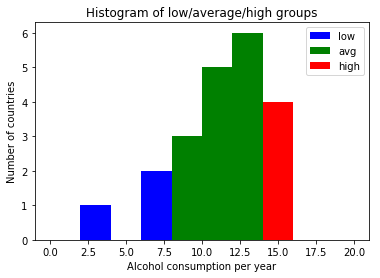

In [91]:
df_per_class = {}
for (group, members) in countries_by_class.items() :
    print('Countries with ' + group + ' alcohol consumption:\n{}'.format(', '.join(members)), end='\n\n')
    df_per_class[group] = df.loc[members]
    df_per_class[group].loc[:, 'alcohol'].hist(grid=False, bins=10, range=(0,20), color=level_colors[group], label=group)
    

plt.xlabel('Alcohol consumption per year')
plt.ylabel('Number of countries')
plt.legend()
plot_title = plt.title('Histogram of low/average/high groups')

### Question one: How does the economy of a country relate to alcohol consumption?

I decided that I will measure a country's economy by the combination of income per person and unemployment rate.

First, I want to decide if I need both variable for my analysis, or are they correlated so much that I could drop one of them? To answer this question, I calculate the correlation of the variables and perfom a PCA. Because I found that unemployment rate doesn't follow normal distribution, I can't use Pearson's R, but I have to use Spearman's $\rho$.

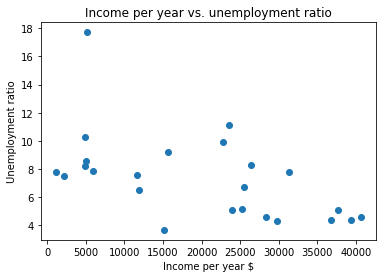

In [92]:
df_econ = df.loc[:, ['income', 'unemployment']]
scatter = plt.scatter(df_econ.iloc[:, 0], df_econ.iloc[:, 1])
plt.ylabel('Unemployment ratio')
plt.xlabel('Income per year $')
plttitle = plt.title('Income per year vs. unemployment ratio')

In [93]:
(r, p) = sts.spearmanr(df_econ.iloc[:, 0], df_econ.iloc[:, 1])
print('r = {0:.3f} (p = {1:.3f})'.format(r, p))

r = -0.563 (p = 0.004)


From this result, I can see that income per person and unemployment rate are negatively correlated. It means that in countries with larger income the unemployment ratio is lower (which makes sense for me). The scatter plot above strengthen this finding.

Next step, I calculated the correlation of these two parameter with the alcohol consumption to decide if there is any linear dependence between any of them.

Correlation of alcohol vs. income: -0.327 (p=0.119)
Correlation of alcohol vs. unemployment: 0.218 (p=0.305)


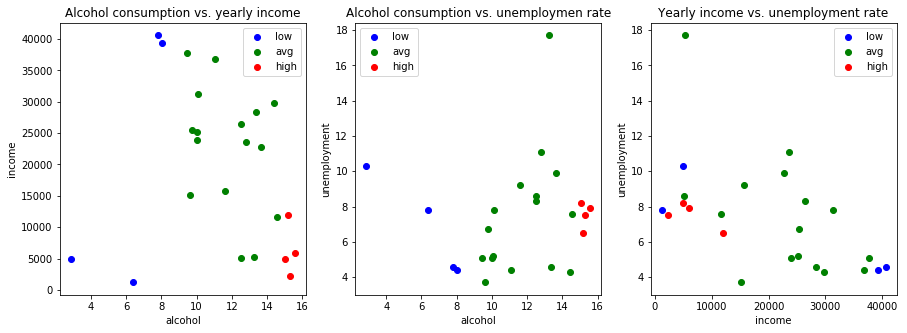

In [94]:
plt.figure(figsize=(15,5))
features = [
    ('alcohol', 'income'),
    ('alcohol', 'unemployment'),
    ('income', 'unemployment')]

plot_titles = [
    'Alcohol consumption vs. yearly income', 
    'Alcohol consumption vs. unemploymen rate',
    'Yearly income vs. unemployment rate']

for i in range(0, len(features)) :
    feature_pair = features[i]
    for group in levels :
        current_group = df.loc[countries_by_class[group]]
        current_color = level_colors[group]
        
        plt.subplot(1, 3, i+1)
        plt.plot(current_group.loc[:, feature_pair[0]], current_group.loc[:, feature_pair[1]], 'o', color=current_color, label=group)
        plt.legend()
        plt.xlabel(feature_pair[0])
        plt.ylabel(feature_pair[1])
        plt.title(plot_titles[i])
        
    
(r, p) = sts.spearmanr(df.loc[:, 'alcohol'], df.loc[:, 'income'])
print('Correlation of alcohol vs. income: {0:.3f} (p={1:.3f})'.format(r, p))
(r, p) = sts.spearmanr(df.loc[:, 'alcohol'], df.loc[:, 'unemployment'])
print('Correlation of alcohol vs. unemployment: {0:.3f} (p={1:.3f})'.format(r, p))

The income and alcohol consumption shows a negative correlation, and we can see that on the first plot too. However, this correlation is not significant (at 0.05 significance level). In contrast, the unemployment rate shows a small positive correlation with the alcohol, but it isn't significant either. Finally, I draw a histogram of the distribution of income/unemployment within groups given by alcohol consumption level.

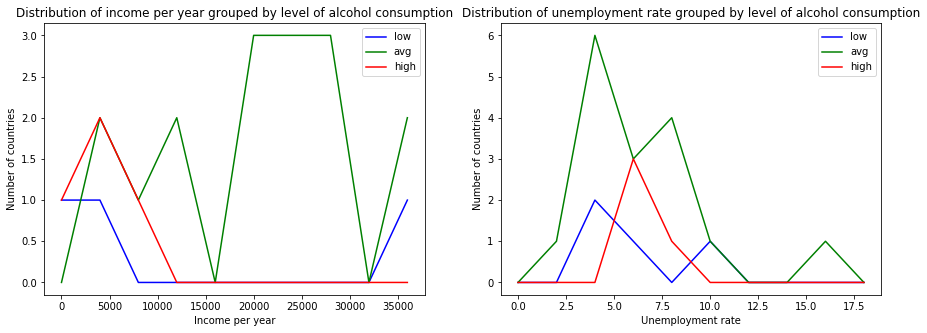

In [95]:
plt.figure(figsize=(15,5))
for group in levels :
    current_group = df.loc[countries_by_class[group]]
    plt.subplot(1, 2, 1);
    y, binedges = np.histogram(current_group.loc[:, 'income'], range=(0,40000), bins=10)
    plt.plot(binedges[:-1], y, color=level_colors[group], label=group)
    plt.xlabel('Income per year')
    plt.ylabel('Number of countries')
    plt.title('Distribution of income per year grouped by level of alcohol consumption')
    plt.legend()
    plt.subplot(1, 2, 2);
    y, binedges = np.histogram(current_group.loc[:, 'unemployment'], range=(0,20), bins=10)
    plt.plot(binedges[:-1], y, color=level_colors[group], label=group)
    plt.xlabel('Unemployment rate')
    plt.ylabel('Number of countries')
    plt.title('Distribution of unemployment rate grouped by level of alcohol consumption')
    plt.legend()

In [96]:
features = ['income', 'unemployment']
for f in range(0, 2) :
    for g1 in range(0, len(levels)-1) :
        group1_name = levels[g1]
        group1 = countries_by_class[group1_name]
        for g2 in range(g1+1, len(levels)) :
            group2_name = levels[g2]
            group2 = countries_by_class[group2_name]
            (t, p) = sts.ttest_ind(df.loc[group1, features[f]], df.loc[group2, features[f]])
            print('ttest: compare {3} between {0} & {1}: p = {2:.3f}'.format(group1_name, group2_name, p, features[f]))

ttest: compare income between low & avg: p = 0.859
ttest: compare income between low & high: p = 0.211
ttest: compare income between avg & high: p = 0.005
ttest: compare unemployment between low & avg: p = 0.726
ttest: compare unemployment between low & high: p = 0.625
ttest: compare unemployment between avg & high: p = 0.970


### Question two: Is there any connection between addiction to alcohol and tobacco?

To answer the second question, I made the same plots as I did in the previous section.

Correlation of alcohol vs. smoking: 0.258 (p=0.224)


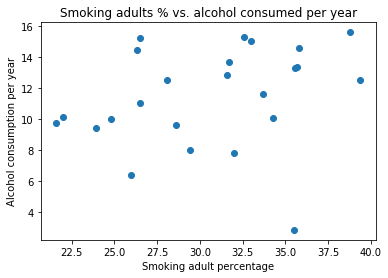

In [97]:
plt.figure()
alcoholvssmoke = plt.scatter(df.loc[:, 'smoking'], df.loc[:, 'alcohol'])
plt.title('Smoking adults % vs. alcohol consumed per year')
plt.ylabel('Alcohol consumption per year')
plt.xlabel('Smoking adult percentage')
(r, p) = sts.pearsonr(df.loc[:, 'smoking'], df.loc[:, 'alcohol'])
print('Correlation of alcohol vs. smoking: {0:.3f} (p={1:.3f})'.format(r, p))

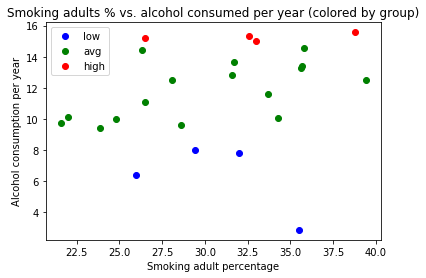

In [98]:
plt.figure()
for group in levels :
    current_group = df.loc[countries_by_class[group]]
    plt.plot(current_group.loc[:, 'smoking'], current_group.loc[:, 'alcohol'], 'o', color=level_colors[group], label=group)
    
plt.title('Smoking adults % vs. alcohol consumed per year (colored by group)')
plt.ylabel('Alcohol consumption per year')
plt.xlabel('Smoking adult percentage')
legend = plt.legend()

ttest: compare smoking between low & avg: p = 0.802
ttest: compare smoking between low & high: p = 0.557
ttest: compare smoking between avg & high: p = 0.376


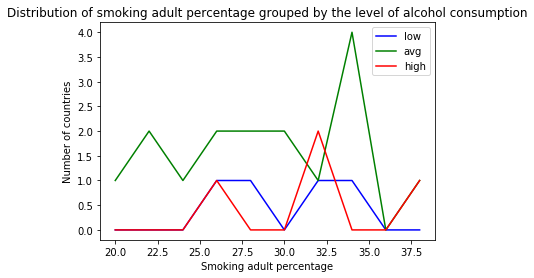

In [99]:
plt.figure()
for group in levels :
    current_group = df.loc[countries_by_class[group]]
    
    y, binedges = np.histogram(current_group.loc[:, 'smoking'], range=(20,40), bins=10)
    plt.plot(binedges[:-1], y, color=level_colors[group], label=group)
    
plt.xlabel('Smoking adult percentage')
plt.ylabel('Number of countries')
plt.title('Distribution of smoking adult percentage grouped by the level of alcohol consumption')
plt.legend()
    
for g1 in range(0, len(levels)-1) :
        group1_name = levels[g1]
        group1 = countries_by_class[group1_name]
        for g2 in range(g1+1, len(levels)) :
            group2_name = levels[g2]
            group2 = countries_by_class[group2_name]
            (t, p) = sts.ttest_ind(df.loc[group1, 'smoking'], df.loc[group2, 'smoking'])
            print('ttest: compare {3} between {0} & {1}: p = {2:.3f}'.format(group1_name, group2_name, p, 'smoking'))

### Question three: Where is Hungary - my home country - on these lists and what can we say about it compared to other countries?

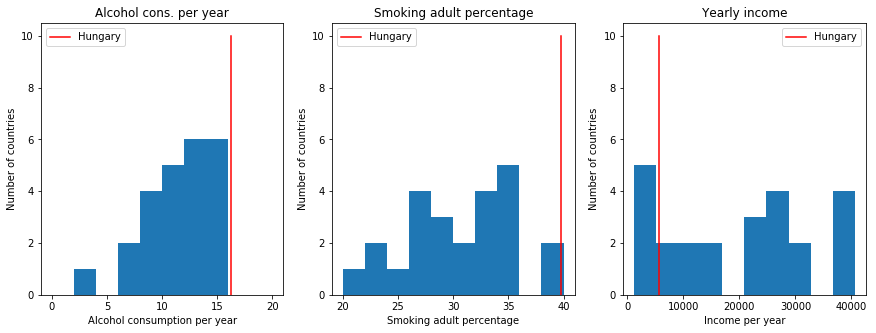

In [100]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.hist(df.loc[:, 'alcohol'], bins=10, range=(0,20))
plot1 = plt.plot(np.dot([1, 1], df_hun['alcohol']), [0, 10], 'r-', label='Hungary')
plt.ylabel('Number of countries')
plt.xlabel('Alcohol consumption per year')
plt.title('Alcohol cons. per year')
plt.legend()
plt.subplot(1, 4, 2)
plt.hist(df.loc[:, 'smoking'], bins=10, range=(20,40))
plot2 = plt.plot(np.dot([1, 1], df_hun['smoking']), [0, 10], 'r-', label='Hungary')
plt.xlabel('Smoking adult percentage')
plt.ylabel('Number of countries')
plt.title('Smoking adult percentage')
plt.legend()
plt.subplot(1, 4, 3)
plt.hist(df.loc[:, 'income'], bins=10)
plot2 = plt.plot(np.dot([1, 1], df_hun['income']), [0, 10], 'r-', label='Hungary')
plt.xlabel('Income per year')
plt.ylabel('Number of countries')
plt.legend()
title = plt.title('Yearly income')

In [101]:
print('Z-score of Hungary at alcohol consumption: {0:.3f}'.format(calc_zscore_single(df, df_hun, 'alcohol')))
print('Z-score of Hungary at smoking: {0:.3f}'.format(calc_zscore_single(df, df_hun, 'smoking')))
print('Z-score of Hungary at income: {0:.3f}'.format(calc_zscore_single(df, df_hun, 'income')))

Z-score of Hungary at alcohol consumption: 1.511
Z-score of Hungary at smoking: 1.806
Z-score of Hungary at income: -1.107


<a id="discussion"></a>
## Discussion

After performing my research described above, I found *some* results, but only some of them turned out to be significant or meaningful.

### Limitations of my analysis

I faced with some difficulties during my analysis. First, I had too few data to draw statistically significant conclusions. I wanted to use the same set of countries for answering both questions, so I could retain only those which has measurement in all four indicators. This was only 24 from the 295. I could chose another year to analyse, but the situation would be worse.

After removing countries with missing values, I had countries mostly from the developed World (USA, Western Europe, Japan, Australia) and I only had a couple of country with worse economy and I didn't have any country from very poor regions (Africa, South America).

Lastly, I wanted to drew some conclusions about the connection between addiction and economy. But the alcohol consumption data doesn't refer to alcohol addicts but the overall alcohol consumption, so possible connection was weakened.

### Question 1
My first question was that is there any connection between alcohol consumption and economic state. I described economy with two variables: income per person and unemployment rate.

My initial hypothesis was that in poor countries and in countries with higher unemployment rate people drink more alcohol. This was a tricky question. The description of the dataset stated a warning: people in poor countries tend to drink cheap, home-made alcohol which doesn't appear in the statistic.
This warning can be true, but on my subset of countries I got different result.

From correlation analysis I got that there is a small negative correlation (-0.327) between alcohol cons. and income and there is a small positive correlation (0.218) between alcohol and unemployment rate. However, these values weren't significant according to statistical test. I performed statistical tests to compare the values between low-, average- and high alcohol countries. The only significant difference was at the income variable between average and high alcohol consumer countries. 

After looking at the scatterplots, I would say that there is a real linear dependence between these two variable, but I don't have enough data to draw significant conclusions.

### Question 2
My second question referred to the addiction to tobacco. My hypothesis was that if somebody is addicted to a bad habit (like smoking) tends to use others too (alcohol).

Based on my data, I couldn't accept my hypothesis. The correlation coefficient was quite small (0.258) and wasn't significant either. The percentage of smoking adults in countries with low-, average- and high alcohol consumption value didn't differ significantly (according to t-test).

I think my previous hypothesis was wrong, because this dataset reports the overall alcohol consumption in a country. But if someone drink alcohol, it doesn't mean that she/he is addicted to it. So, maybe if I would have a dataset with the percentage of alcohol addicts I could show significant connection.

### Question 3
Sadly, for this last question I could say stronger results. I inspected my home country how does it perform with these three variables: alcohol, income and smoking (unemployment rate was missing). I made 3 histograms showing the distribution of the variables and I drew a line on it to the value of Hungary.

On all of the three plots the red line fall to the (worse) edge of the histogram: smoking and alcohol consumption was higher than any other country's in my dataset, and the income was one of the lowest.

Because these three variables followed a normal distribution, I calculated the z-score of Hungary. All value differed from the average more than 1 SD, the percentage of somking adults almost reached the 2SD.

As a final conclusion: I think my initial hypotheses came from what I see here, so I have to be careful, not to judge the whole World after a small part of it.